## **Reading the Dataset as a DataFrame**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Final Year Paper Work/Complete Summarized Dataset.xlsx', header=0,index_col=0)

df = df.dropna() # To remove any None values
df.head()

Judgement    Domain  \
Id                                                                
1   appeal judgment decre bombay high court stone ...     Civil   
2   applic articl 32 1 constitut enforc applic fun...     Civil   
3   appeal judgment high court hyderabad articl 37...     Civil   
4   appeal articl 3744 constitut judgment decre hi...     Civil   
5   petit art 136 constitut pray special leav appe...  Criminal   

    Judgement Status          Court  \
Id                                    
1                  1  Supreme Court   
2                  2  Supreme Court   
3                  0  Supreme Court   
4                  0  Supreme Court   
5                  3  Supreme Court   

                    Abstractive Summarized Judgements  \
Id                                                      
1   In order to enforce war-time controls another ...   
2   The second part of this bye-law clearly contem...   
3   The learned advocate for the appellant contend...   
4   It has been held that the first appellate cour...   
5   It was pointed out that in respect of convicti...   

                     Extractive Summarized Judgements  
Id                                                     
1   According to the Respondent, on the 11th Augus...  
2   This is an application under article 32 of the...  
3   749 The sole point for determination in the ap...  
4   This objection was overruled by the court and ...  
5   The petitioners have now filed their petitions...

##**Splitting the data for complete, extractive and abstractive summarized texts**

In [3]:
# Complete Data
com_sentences = df[['Judgement','Judgement Status']]

# Abstractive Data
abs_sentences = df[['Abstractive Summarized Judgements','Judgement Status']]

# Extractive Data
ext_sentences = df[['Extractive Summarized Judgements','Judgement Status']]

from sklearn.model_selection import train_test_split

# Train and Test Split for Complete Data
df_train_com, df_test_com = train_test_split(com_sentences, test_size=0.25, random_state=42)

# Train and Test Split for Abstractive Data
df_train_abs, df_test_abs = train_test_split(abs_sentences, test_size=0.25, random_state=42)

# Train and Test Split for Extractive Data
df_train_ext, df_test_ext = train_test_split(ext_sentences, test_size=0.25, random_state=42)

## **Converting the Judgement Status to Categorical Values**

In [4]:
from tensorflow.keras.utils import to_categorical

# Complete Data
y_train_com = to_categorical(df_train_com['Judgement Status'])
y_test_com = to_categorical(df_test_com['Judgement Status'])

# Abstractive Data
y_train_abs = to_categorical(df_train_abs['Judgement Status'])
y_test_abs = to_categorical(df_test_abs['Judgement Status'])

# Extractive Data
y_train_ext = to_categorical(df_train_ext['Judgement Status'])
y_test_ext = to_categorical(df_test_ext['Judgement Status'])

## **Import Statements**

In [23]:
!pip install transformers lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=e76a0192f83a271b2add7c8edb95e5338a15f6bcfe453af5981d2567c7bdb0d4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [7]:
# Import Statements
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers

In [8]:
from transformers import BertConfig, RobertaTokenizer, TFRobertaModel

# Load the tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/tokenizer.json


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.j

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/model.safetensors
Loaded 124,055,040 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not init

##**1) Complete Data**

In [9]:
df_com_roberta = df
df_com_roberta = df_com_roberta.rename(columns = {'Judgement Status': 'label', 'Judgement': 'text'}, inplace = False)
print('Available labels: ',df_com_roberta.label.unique())

num_classes_com_roberta = len(df_com_roberta.label.unique())
df_com_roberta.head()

Available labels:  [1 2 0 3]


text    Domain  label  \
Id                                                                       
1   appeal judgment decre bombay high court stone ...     Civil      1   
2   applic articl 32 1 constitut enforc applic fun...     Civil      2   
3   appeal judgment high court hyderabad articl 37...     Civil      0   
4   appeal articl 3744 constitut judgment decre hi...     Civil      0   
5   petit art 136 constitut pray special leav appe...  Criminal      3   

            Court                  Abstractive Summarized Judgements  \
Id                                                                     
1   Supreme Court  In order to enforce war-time controls another ...   
2   Supreme Court  The second part of this bye-law clearly contem...   
3   Supreme Court  The learned advocate for the appellant contend...   
4   Supreme Court  It has been held that the first appellate cour...   
5   Supreme Court  It was pointed out that in respect of convicti...   

                     Extractive Summarized Judgements  
Id                                                     
1   According to the Respondent, on the 11th Augus...  
2   This is an application under article 32 of the...  
3   749 The sole point for determination in the ap...  
4   This objection was overruled by the court and ...  
5   The petitioners have now filed their petitions...

In [10]:
max_len = 100
sentences_com_roberta = df_com_roberta['text']
labels_com_roberta = df_com_roberta['label']
len(sentences_com_roberta), len(labels_com_roberta)

(593, 593)

### **Checking if the Tokenizer is working well with out data by giving one sentence as input**

In [11]:
roberta_tokenizer.tokenize(sentences_com_roberta[1])

roberta_inp_com = roberta_tokenizer.encode_plus(sentences_com_roberta[1],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)
roberta_inp_com

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [0, 3340, 18696, 7579, 33186, 4840, 857, 239, 461, 7326, 740, 267, 20176, 1176, 242, 1236, 1248, 291, 212, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
id_inp_com_roberta = np.asarray(roberta_inp_com['input_ids'])
mask_inp_com_roberta = np.asarray(roberta_inp_com['attention_mask'])
out_com_roberta = roberta_model([id_inp_com_roberta.reshape(1,-1),mask_inp_com_roberta.reshape(1,-1)])
type(out_com_roberta),out_com_roberta

(transformers.modeling_tf_outputs.TFBaseModelOutputWithPoolingAndCrossAttentions,
 TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
 array([[[ 0.00362617,  0.04238947, -0.00140104, ..., -0.0670489 ,
          -0.05937958, -0.00580116],
         [ 0.18783864,  0.07072069,  0.13693428, ..., -0.08827943,
          -0.09105258, -0.05657107],
         [ 0.15672877,  0.11918226,  0.09171341, ..., -0.18483827,
          -0.09458219,  0.15510277],
         ...,
         [ 0.09059416, -0.1541655 ,  0.07239639, ...,  0.0680743 ,
          -0.04213015,  0.16400847],
         [ 0.05202321, -0.03960689, -0.07395999, ..., -0.42455322,
          -0.03463601,  0.13133606],
         [ 0.01829152,  0.04010895, -0.02119468, ..., -0.10150351,
          -0.05976529, -0.02878152]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[ 3.32441181e-02,  1.33497477e-01,  5.95469438e-02,
          1.35618

In [13]:
roberta_tokenizer.decode(roberta_inp_com['input_ids'])

'<s>appeal judgment decre bombay high court stone cj coyaje j date 20th</s>'

### **Since tokenizer is working well, run the tokenizer with all sentences**

In [14]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    roberta_layer = roberta_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(128,activation='relu')(roberta_layer)
    dropout= Dropout(0.1)(dense)
    dense = Dense(32,activation = 'relu')(dropout)
    pred = Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dense)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

model_com_roberta = create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 100, 7                                           
                             68),                                                             

In [15]:
input_ids_com_roberta = []
attention_masks_com_roberta = []

for sent in sentences_com_roberta:
    roberta_inps_com = roberta_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids_com_roberta.append(roberta_inps_com['input_ids'])
    attention_masks_com_roberta.append(roberta_inps_com['attention_mask'])

input_ids_com_roberta = np.asarray(input_ids_com_roberta)
attention_masks_com_roberta = np.array(attention_masks_com_roberta)
labels_com_roberta = np.array(labels_com_roberta)
len(input_ids_com_roberta),len(attention_masks_com_roberta),len(labels_com_roberta)

(593, 593, 593)

In [16]:
train_inp_com_roberta, val_inp_com_roberta, train_label_com_roberta, val_label_com_roberta, train_mask_com_roberta, val_mask_com_roberta = train_test_split(input_ids_com_roberta,labels_com_roberta,attention_masks_com_roberta,test_size=0.25)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp_com_roberta.shape,val_inp_com_roberta.shape,train_label_com_roberta.shape,val_label_com_roberta.shape,train_mask_com_roberta.shape,val_mask_com_roberta.shape))

loss_com_roberta = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_com_roberta = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer_com_roberta = tf.keras.optimizers.Adam(learning_rate=3e-5)

model_com_roberta.compile(loss=loss_com_roberta, optimizer=optimizer_com_roberta, metrics=[metric_com_roberta])

Train inp shape (444, 100) Val input shape (149, 100)
Train label shape (444,) Val label shape (149,)
Train attention mask shape (444, 100) Val attention mask shape (149, 100)


In [17]:
history_com_roberta = model_com_roberta.fit([train_inp_com_roberta,train_mask_com_roberta],train_label_com_roberta,batch_size = 32,epochs = 10,validation_data=([val_inp_com_roberta,val_mask_com_roberta],val_label_com_roberta))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/14 [==============================] - 57s 910ms/step - loss: 1.4627 - accuracy: 0.2995 - val_loss: 1.4632 - val_accuracy: 0.2282
Epoch 2/10
14/14 [==============================] - 10s 698ms/step - loss: 1.4214 - accuracy: 0.3018 - val_loss: 1.4335 - val_accuracy: 0.2819
Epoch 3/10
14/14 [==============================] - 10s 698ms/step - loss: 1.3034 - accuracy: 0.3649 - val_loss: 1.3590 - val_accuracy: 0.3356
Epoch 4/10
14/14 [==============================] - 10s 713ms/step - loss: 1.1656 - accuracy: 0.4032 - val_loss: 1.3380 - val_accuracy: 0.4094
Epoch 5/10
14/14 [==============================] - 12s 842ms/step - loss: 1.1074 - accuracy: 0.4459 - val_loss: 1.2537 - val_accuracy: 0.3758
Epoch 6/10
14/14 [==============================] - 10s 708ms/step - loss: 1.0298 - accuracy: 0.4234 - val_loss: 1.2593 - val_accuracy: 0.4430
Epoch 7/10
14/14 [==============================] - 10s 713ms/step - loss: 0.9425 - accuracy: 0.5270 - val_loss: 1.3219 - val_accuracy: 0.4161
Epoch 8/10

In [18]:
preds_com_roberta = model_com_roberta.predict([val_inp_com_roberta,val_mask_com_roberta],batch_size=16)

10/10 [==============================] - 4s 118ms/step


In [19]:
pred_labels_com_roberta = preds_com_roberta.argmax(axis=1)
f1_com_roberta = f1_score(val_label_com_roberta,pred_labels_com_roberta,average='weighted')
print("F1 Score: ",f1_com_roberta)

F1 Score:  0.40388011055290246


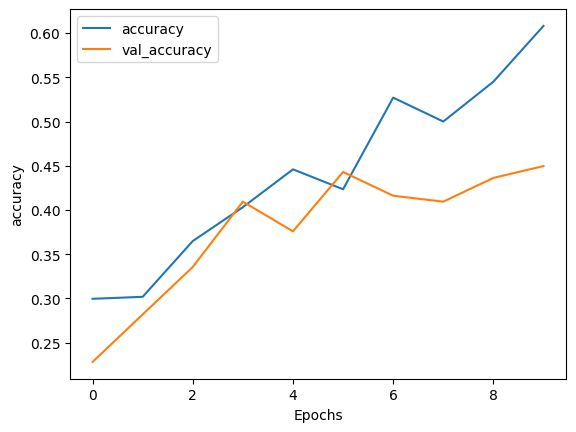

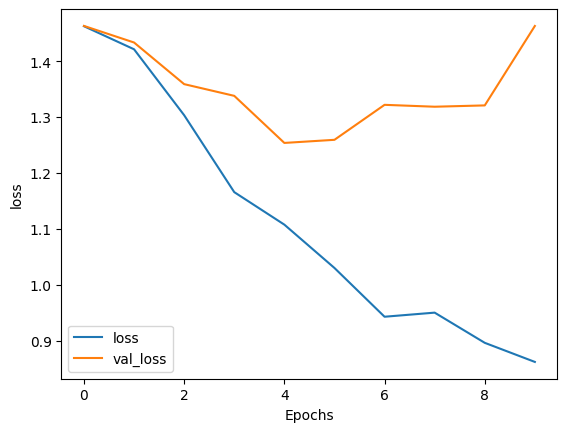

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_com_roberta, "accuracy")
plot_graphs(history_com_roberta, "loss")

In [21]:
model_com_roberta.save("/content/drive/MyDrive/Final Year Paper Work/RoBERTa H5 Files/COM-ROBERTA.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Import necessary libraries
from lime import lime_text

# Define the function to predict using the RoBERT model with truncation and padding
def predict_fn(x):
    inputs = roberta_tokenizer(x, return_tensors='tf', truncation=True, padding=True, max_length=100)
    return model_com_roberta.predict([inputs['input_ids'], inputs['attention_mask']])

# Create a LIME explainer
explainer = lime_text.LimeTextExplainer()

# Choose a sample from the test set for explanation
sample_index = 0  # You can change this index as needed
text_to_explain = df_test_com['Judgement'].iloc[sample_index]
explanation_class = np.argmax(y_test_com[sample_index])  # Get the index of the maximum value as the class

# Generate LIME explanation
exp = explainer.explain_instance(
    text_to_explain,
    predict_fn,
    num_features=10,
    num_samples=5000,
    labels=list(range(y_test_com.shape[1])) if len(y_test_com.shape) > 1 else None
)

# Print and visualize the explanation
print('Explanation for class', explanation_class)
print(exp.as_list())

# Visualize the explanation
exp.show_in_notebook(text=text_to_explain)

157/157 [==============================] - 36s 212ms/step
Explanation for class 1
[('incometax', 0.07561840043925232), ('appeal', 0.05333979889981442), ('judgment', -0.037249553814945456), ('high', -0.032308766784451964), ('calcutta', -0.031810832074190304), ('court', -0.029472306933923113), ('chakravartti', -0.026959228000584402), ('c', 0.014224853160202618), ('refer', 0.010854422533484754), ('date', 0.00854587874750876)]


##**2) Abstractive Summarized Data**


In [26]:
df_abs_roberta = df
df_abs_roberta = df_abs_roberta.rename(columns = {'Judgement Status': 'label', 'Abstractive Summarized Judgements': 'text'}, inplace = False)
print('Available labels: ',df_abs_roberta.label.unique())

num_classes_abs__roberta = len(df_abs_roberta.label.unique())
df_abs_roberta.head()

Available labels:  [1 2 0 3]


Judgement    Domain  label  \
Id                                                                       
1   appeal judgment decre bombay high court stone ...     Civil      1   
2   applic articl 32 1 constitut enforc applic fun...     Civil      2   
3   appeal judgment high court hyderabad articl 37...     Civil      0   
4   appeal articl 3744 constitut judgment decre hi...     Civil      0   
5   petit art 136 constitut pray special leav appe...  Criminal      3   

            Court                                               text  \
Id                                                                     
1   Supreme Court  In order to enforce war-time controls another ...   
2   Supreme Court  The second part of this bye-law clearly contem...   
3   Supreme Court  The learned advocate for the appellant contend...   
4   Supreme Court  It has been held that the first appellate cour...   
5   Supreme Court  It was pointed out that in respect of convicti...   

                     Extractive Summarized Judgements  
Id                                                     
1   According to the Respondent, on the 11th Augus...  
2   This is an application under article 32 of the...  
3   749 The sole point for determination in the ap...  
4   This objection was overruled by the court and ...  
5   The petitioners have now filed their petitions...

In [27]:
max_len = 100
sentences_abs_roberta = df_abs_roberta['text']
labels_abs_roberta = df_abs_roberta['label']
len(sentences_abs_roberta), len(labels_abs_roberta)

(593, 593)

### **Checking if the Tokenizer is working well with out data by giving one sentence as input**

In [28]:
roberta_tokenizer.tokenize(sentences_abs_roberta[1])

roberta_inp_abs = roberta_tokenizer.encode_plus(sentences_abs_roberta[1],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)
roberta_inp_abs

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [0, 1121, 645, 7, 10914, 997, 12, 958, 5656, 277, 8322, 9, 5, 15687, 12, 18712, 21, 156, 23920, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [29]:
id_inp_abs_roberta = np.asarray(roberta_inp_abs['input_ids'])
mask_inp_abs_roberta = np.asarray(roberta_inp_abs['attention_mask'])
out_abs_roberta = roberta_model([id_inp_abs_roberta.reshape(1,-1),mask_inp_abs_roberta.reshape(1,-1)])
type(out_abs_roberta),out_abs_roberta

(transformers.modeling_tf_outputs.TFBaseModelOutputWithPoolingAndCrossAttentions,
 TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
 array([[[-0.00133733,  0.17682694, -0.11130665, ...,  0.11508492,
          -0.05003196, -0.20203587],
         [ 0.21495041,  0.34015036, -0.0542464 , ...,  0.35095847,
          -0.13549602, -0.17002696],
         [ 0.24689987,  0.63510287,  0.34429902, ...,  0.88073725,
          -0.18764299, -0.04914726],
         ...,
         [ 0.33536685, -0.03422993,  0.2970167 , ...,  0.9636377 ,
           0.14386967, -0.19110899],
         [ 0.3632799 ,  0.15380985,  0.04326139, ...,  0.48781738,
           0.01499455, -0.13967288],
         [-0.00861397,  0.17561229, -0.11659462, ...,  0.10223368,
          -0.05365925, -0.19922741]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[ 8.73751566e-02,  2.73688525e-01,  1.32329941e-01,
          2.58161

In [30]:
roberta_tokenizer.decode(roberta_inp_abs['input_ids'])

'<s>In order to enforce war-time controls another amendment of the bye-laws was made whereby</s>'

### **Since tokenizer is working well, run the tokenizer with all sentences**

In [31]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    roberta_layer = roberta_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(128,activation='relu')(roberta_layer)
    dropout= Dropout(0.1)(dense)
    dense = Dense(32,activation = 'relu')(dropout)
    pred = Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dense)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

model_abs_roberta = create_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 100, 7                                           
                             68),                                                           

In [32]:
input_ids_abs_roberta = []
attention_masks_abs_roberta = []

for sent in sentences_abs_roberta:
    roberta_inps_abs = roberta_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids_abs_roberta.append(roberta_inps_abs['input_ids'])
    attention_masks_abs_roberta.append(roberta_inps_abs['attention_mask'])

input_ids_abs_roberta = np.asarray(input_ids_abs_roberta)
attention_masks_abs_roberta = np.array(attention_masks_abs_roberta)
labels_abs_roberta = np.array(labels_abs_roberta)
len(input_ids_abs_roberta),len(attention_masks_abs_roberta),len(labels_abs_roberta)

(593, 593, 593)

In [33]:
train_inp_abs_roberta, val_inp_abs_roberta, train_label_abs_roberta, val_label_abs_roberta, train_mask_abs_roberta, val_mask_abs_roberta = train_test_split(input_ids_abs_roberta,labels_abs_roberta,attention_masks_abs_roberta,test_size=0.25)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp_abs_roberta.shape,val_inp_abs_roberta.shape,train_label_abs_roberta.shape,val_label_abs_roberta.shape,train_mask_abs_roberta.shape,val_mask_abs_roberta.shape))

loss_abs_roberta = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_abs_roberta = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer_abs_roberta = tf.keras.optimizers.Adam(learning_rate=3e-5)

model_abs_roberta.compile(loss=loss_abs_roberta, optimizer=optimizer_abs_roberta, metrics=[metric_abs_roberta])

Train inp shape (444, 100) Val input shape (149, 100)
Train label shape (444,) Val label shape (149,)
Train attention mask shape (444, 100) Val attention mask shape (149, 100)


In [34]:
history_abs_roberta = model_abs_roberta.fit([train_inp_abs_roberta,train_mask_abs_roberta],train_label_abs_roberta,batch_size = 32,epochs = 10,validation_data=([val_inp_abs_roberta,val_mask_abs_roberta],val_label_abs_roberta))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/14 [==============================] - 63s 943ms/step - loss: 1.4984 - accuracy: 0.2748 - val_loss: 1.4515 - val_accuracy: 0.3154
Epoch 2/10
14/14 [==============================] - 10s 725ms/step - loss: 1.4627 - accuracy: 0.2703 - val_loss: 1.4854 - val_accuracy: 0.2617
Epoch 3/10
14/14 [==============================] - 11s 798ms/step - loss: 1.4411 - accuracy: 0.3153 - val_loss: 1.4477 - val_accuracy: 0.3154
Epoch 4/10
14/14 [==============================] - 10s 749ms/step - loss: 1.3969 - accuracy: 0.3761 - val_loss: 1.4387 - val_accuracy: 0.2953
Epoch 5/10
14/14 [==============================] - 11s 760ms/step - loss: 1.3478 - accuracy: 0.3829 - val_loss: 1.4870 - val_accuracy: 0.3087
Epoch 6/10
14/14 [==============================] - 10s 754ms/step - loss: 1.2403 - accuracy: 0.4527 - val_loss: 1.4458 - val_accuracy: 0.2953
Epoch 7/10
14/14 [==============================] - 10s 741ms/step - loss: 1.0744 - accuracy: 0.5428 - val_loss: 1.6036 - val_accuracy: 0.3087
Epoch 8/10

In [35]:
preds_abs_roberta = model_abs_roberta.predict([val_inp_abs_roberta,val_mask_abs_roberta],batch_size=16)

10/10 [==============================] - 4s 118ms/step


In [36]:
pred_labels_abs_roberta = preds_abs_roberta.argmax(axis=1)
f1_abs_roberta = f1_score(val_label_abs_roberta,pred_labels_abs_roberta,average='weighted')
print("F1 Score: ",f1_abs_roberta)

F1 Score:  0.3493509169572329


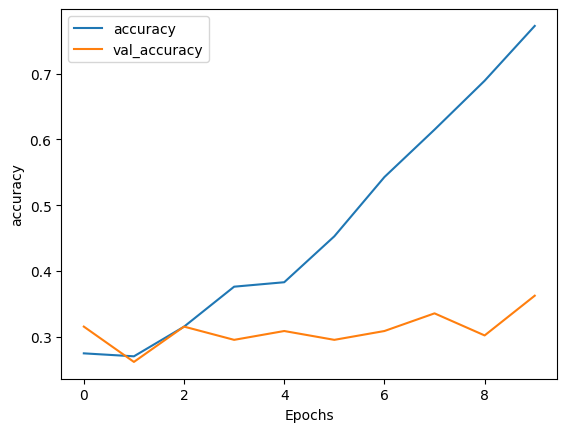

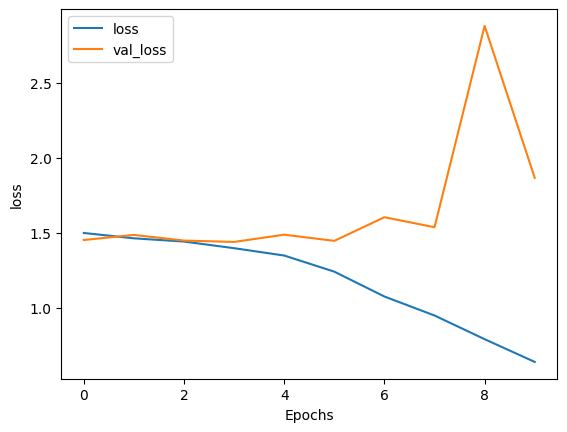

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_abs_roberta, "accuracy")
plot_graphs(history_abs_roberta, "loss")

In [38]:
model_abs_roberta.save("/content/drive/MyDrive/Final Year Paper Work/RoBERTa H5 Files/ABS-ROBERTA.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# Import necessary libraries
from lime import lime_text

# Define the function to predict using the RoBERT model with truncation and padding
def predict_fn(x):
    inputs = roberta_tokenizer(x, return_tensors='tf', truncation=True, padding=True, max_length=100)
    return model_abs_roberta.predict([inputs['input_ids'], inputs['attention_mask']])

# Create a LIME explainer
explainer = lime_text.LimeTextExplainer()

# Choose a sample from the test set for explanation
sample_index = 0  # You can change this index as needed
text_to_explain = df_test_abs['Abstractive Summarized Judgements'].iloc[sample_index]
explanation_class = np.argmax(y_test_abs[sample_index])  # Get the index of the maximum value as the class

# Generate LIME explanation
exp = explainer.explain_instance(
    text_to_explain,
    predict_fn,
    num_features=10,
    num_samples=5000,
    labels=list(range(y_test_abs.shape[1])) if len(y_test_abs.shape) > 1 else None
)

# Print and visualize the explanation
print('Explanation for class', explanation_class)
print(exp.as_list())

# Visualize the explanation
exp.show_in_notebook(text=text_to_explain)

157/157 [==============================] - 38s 216ms/step
Explanation for class 1
[('held', 0.25995467467892924), ('the', 0.17634274604588293), ('It', 0.1741565026697949), ('void', 0.16600319259865218), ('that', 0.15689204692484024), ('I', 0.13658249988217425), ('of', 0.13605702551156731), ('deed', 0.10567552240220329), ('Court', 0.10486820885863052), ('provisions', 0.08575916799025379)]


## **3) Extractive Summarized Data**

In [41]:
df_ext_roberta = df
df_ext_roberta = df_ext_roberta.rename(columns = {'Judgement Status': 'label', 'Extractive Summarized Judgements': 'text'}, inplace = False)
print('Available labels: ',df_ext_roberta.label.unique())

num_classes_ext_roberta = len(df_ext_roberta.label.unique())
df_ext_roberta.head()

Available labels:  [1 2 0 3]


Judgement    Domain  label  \
Id                                                                       
1   appeal judgment decre bombay high court stone ...     Civil      1   
2   applic articl 32 1 constitut enforc applic fun...     Civil      2   
3   appeal judgment high court hyderabad articl 37...     Civil      0   
4   appeal articl 3744 constitut judgment decre hi...     Civil      0   
5   petit art 136 constitut pray special leav appe...  Criminal      3   

            Court                  Abstractive Summarized Judgements  \
Id                                                                     
1   Supreme Court  In order to enforce war-time controls another ...   
2   Supreme Court  The second part of this bye-law clearly contem...   
3   Supreme Court  The learned advocate for the appellant contend...   
4   Supreme Court  It has been held that the first appellate cour...   
5   Supreme Court  It was pointed out that in respect of convicti...   

                                                 text  
Id                                                     
1   According to the Respondent, on the 11th Augus...  
2   This is an application under article 32 of the...  
3   749 The sole point for determination in the ap...  
4   This objection was overruled by the court and ...  
5   The petitioners have now filed their petitions...

In [42]:
max_len = 100
sentences_ext_roberta = df_ext_roberta['text']
labels_ext_roberta = df_ext_roberta['label']
len(sentences_ext_roberta), len(labels_ext_roberta)

(593, 593)

### **Checking if the Tokenizer is working well with out data by giving one sentence as input**

In [43]:
roberta_tokenizer.tokenize(sentences_ext_roberta[1])

roberta_inp_ext = roberta_tokenizer.encode_plus(sentences_ext_roberta[1],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)
roberta_inp_ext

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [0, 14693, 7, 5, 16533, 1342, 6, 15, 5, 365, 212, 830, 6, 21123, 6, 5, 16533, 1342, 14027, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
id_inp_ext_roberta = np.asarray(roberta_inp_ext['input_ids'])
mask_inp_ext_roberta = np.asarray(roberta_inp_ext['attention_mask'])
out_ext_roberta = roberta_model([id_inp_ext_roberta.reshape(1,-1),mask_inp_ext_roberta.reshape(1,-1)])
type(out_ext_roberta),out_ext_roberta

(transformers.modeling_tf_outputs.TFBaseModelOutputWithPoolingAndCrossAttentions,
 TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
 array([[[-1.4016308e-01,  8.2096756e-03,  4.0345439e-01, ...,
          -1.5854734e-01, -8.2966417e-02, -2.5971785e-02],
         [-3.1160444e-02,  3.5649946e-01,  1.6916844e-01, ...,
          -9.5721239e-01, -1.4648610e-01,  8.2274899e-04],
         [ 1.1305578e-02,  2.6432079e-01,  1.5016559e-01, ...,
          -1.6425457e+00, -5.6961161e-01,  3.6532789e-01],
         ...,
         [-1.9205077e-01,  5.0162617e-02, -1.2720302e-01, ...,
          -4.8111677e-01,  2.2352263e-01,  1.3553041e-01],
         [-3.4190172e-01,  3.7239528e-01,  2.3499343e-01, ...,
          -3.7101865e-01, -1.8438667e-01, -8.7218605e-02],
         [-1.4338812e-01,  6.0606082e-03,  4.0533653e-01, ...,
          -1.6356567e-01, -8.4951349e-02, -2.7460869e-02]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(

In [45]:
roberta_tokenizer.decode(roberta_inp_ext['input_ids'])

'<s>According to the Respondent, on the 11th August, 1945, the Respondent instructed</s>'

### **Since tokenizer is working well, run the tokenizer with all sentences**

In [46]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    roberta_layer = roberta_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(128,activation='relu')(roberta_layer)
    dropout= Dropout(0.1)(dense)
    dense = Dense(32,activation = 'relu')(dropout)
    pred = Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dense)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

model_ext_roberta = create_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_5[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_6[0][0]']             
                             hidden_state=(None, 100, 7                                           
                             68),                                                           

In [47]:
input_ids_ext_roberta = []
attention_masks_ext_roberta = []

for sent in sentences_ext_roberta:
    roberta_inps_ext = roberta_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids_ext_roberta.append(roberta_inps_ext['input_ids'])
    attention_masks_ext_roberta.append(roberta_inps_ext['attention_mask'])

input_ids_ext_roberta = np.asarray(input_ids_ext_roberta)
attention_masks_ext_roberta = np.array(attention_masks_ext_roberta)
labels_ext_roberta = np.array(labels_ext_roberta)
len(input_ids_ext_roberta),len(attention_masks_ext_roberta),len(labels_ext_roberta)

(593, 593, 593)

In [48]:
train_inp_ext_roberta, val_inp_ext_roberta, train_label_ext_roberta, val_label_ext_roberta, train_mask_ext_roberta, val_mask_ext_roberta = train_test_split(input_ids_ext_roberta,labels_ext_roberta,attention_masks_ext_roberta,test_size=0.25)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp_ext_roberta.shape,val_inp_ext_roberta.shape,train_label_ext_roberta.shape,val_label_ext_roberta.shape,train_mask_ext_roberta.shape,val_mask_ext_roberta.shape))

loss_ext_roberta = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_ext_roberta = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer_ext_roberta = tf.keras.optimizers.Adam(learning_rate=3e-5)

model_ext_roberta.compile(loss=loss_ext_roberta, optimizer=optimizer_ext_roberta, metrics=[metric_ext_roberta])

Train inp shape (444, 100) Val input shape (149, 100)
Train label shape (444,) Val label shape (149,)
Train attention mask shape (444, 100) Val attention mask shape (149, 100)


In [49]:
history_ext_roberta = model_ext_roberta.fit([train_inp_ext_roberta,train_mask_ext_roberta],train_label_ext_roberta,batch_size = 32,epochs = 10,validation_data=([val_inp_ext_roberta,val_mask_ext_roberta],val_label_ext_roberta))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/14 [==============================] - 55s 954ms/step - loss: 1.4756 - accuracy: 0.2748 - val_loss: 1.3183 - val_accuracy: 0.3960
Epoch 2/10
14/14 [==============================] - 10s 752ms/step - loss: 1.2991 - accuracy: 0.4482 - val_loss: 1.1591 - val_accuracy: 0.4362
Epoch 3/10
14/14 [==============================] - 11s 765ms/step - loss: 1.2128 - accuracy: 0.4392 - val_loss: 1.1659 - val_accuracy: 0.4362
Epoch 4/10
14/14 [==============================] - 11s 768ms/step - loss: 1.1077 - accuracy: 0.5225 - val_loss: 1.2577 - val_accuracy: 0.4161
Epoch 5/10
14/14 [==============================] - 10s 736ms/step - loss: 1.0673 - accuracy: 0.5203 - val_loss: 1.1935 - val_accuracy: 0.4362
Epoch 6/10
14/14 [==============================] - 10s 746ms/step - loss: 0.9521 - accuracy: 0.5991 - val_loss: 1.2050 - val_accuracy: 0.5034
Epoch 7/10
14/14 [==============================] - 10s 738ms/step - loss: 0.8487 - accuracy: 0.6644 - val_loss: 1.2445 - val_accuracy: 0.4631
Epoch 8/10

In [50]:
preds_ext_roberta = model_ext_roberta.predict([val_inp_ext_roberta,val_mask_ext_roberta],batch_size=16)

10/10 [==============================] - 4s 108ms/step


In [51]:
pred_labels_ext_roberta = preds_ext_roberta.argmax(axis=1)
f1_ext_roberta = f1_score(val_label_ext_roberta,pred_labels_ext_roberta,average='weighted')
print("F1 Score: ",f1_ext_roberta)

F1 Score:  0.42686083702318406


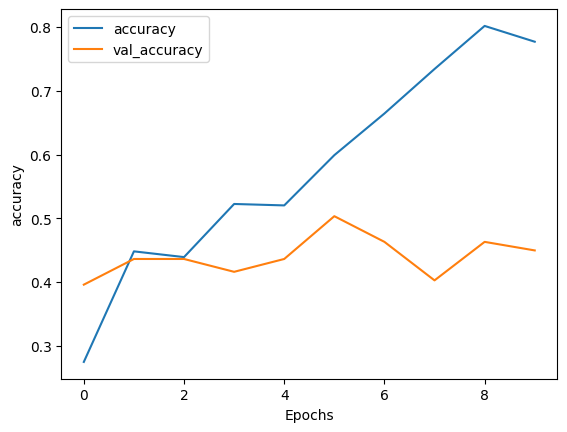

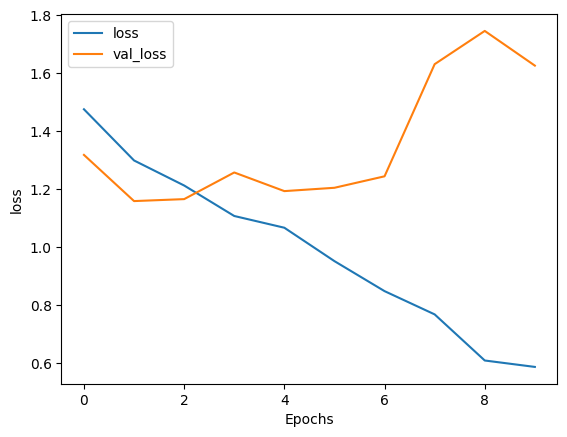

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_ext_roberta, "accuracy")
plot_graphs(history_ext_roberta, "loss")

In [53]:
model_ext_roberta.save("/content/drive/MyDrive/Final Year Paper Work/RoBERTa H5 Files/EXT-ROBERTA.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
# Import necessary libraries
from lime import lime_text

# Define the function to predict using the RoBERT model with truncation and padding
def predict_fn(x):
    inputs = roberta_tokenizer(x, return_tensors='tf', truncation=True, padding=True, max_length=100)
    return model_ext_roberta.predict([inputs['input_ids'], inputs['attention_mask']])

# Create a LIME explainer
explainer = lime_text.LimeTextExplainer()

# Choose a sample from the test set for explanation
sample_index = 0  # You can change this index as needed
text_to_explain = df_test_ext['Extractive Summarized Judgements'].iloc[sample_index]
explanation_class = np.argmax(y_test_ext[sample_index])  # Get the index of the maximum value as the class

# Generate LIME explanation
exp = explainer.explain_instance(
    text_to_explain,
    predict_fn,
    num_features=10,
    num_samples=5000,
    labels=list(range(y_test_ext.shape[1])) if len(y_test_ext.shape) > 1 else None
)

# Print and visualize the explanation
print('Explanation for class', explanation_class)
print(exp.as_list())

# Visualize the explanation
exp.show_in_notebook(text=text_to_explain)

157/157 [==============================] - 38s 218ms/step
Explanation for class 1
[('of', 0.20529910836397303), ('Court', 0.1399466806279344), ('Calcutta', 0.13575490490551054), ('1922', 0.11013329954198912), ('held', 0.09797975275251629), ('The', 0.08779860291613652), ('that', 0.07904252986896607), ('BHAGWATI', 0.07187742365235816), ('Judgment', 0.0682850889238793), ('the', 0.06563519255288615)]
